In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import nltk
import string
import matplotlib.pyplot as plt
import sklearn
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /home/xz/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/xz/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/xz/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/xz/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

# Data exploration

In [10]:
# !mkdir -p data
# !wget -nc https://nyc3.digitaloceanspaces.com/ml-files-distro/v1/sentiment-analysis-is-bad/data/training.1600000.processed.noemoticon.csv.zip -P data
# !unzip -n -d data data/training.1600000.processed.noemoticon.csv.zip

In [3]:
df = pd.read_csv("data/training.1600000.processed.noemoticon.csv",
                names=['targets', 'id', 'date', 'query', 'user', 'text'],
                encoding='latin-1')

In [4]:
df.targets.replace(4, 1, inplace=True)

In [5]:
df_sample = df.sample(frac=0.1, random_state=1)

<AxesSubplot:xlabel='targets', ylabel='Count'>

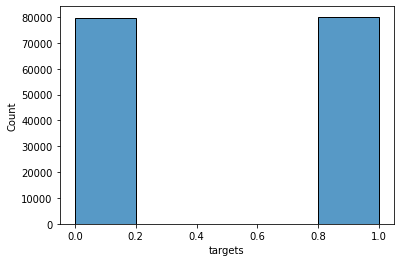

In [6]:
sns.histplot(df_sample, x='targets', binwidth = 0.2)

# Train test split

In [7]:
df_train = df_sample.sample(frac = 0.8, random_state = 1)
df_valid = df_sample[~df_sample.id.isin(df_train.id)]
df_test = df_valid.sample(frac = 0.5, random_state = 1)
df_valid = df_valid[~df_valid.id.isin(df_test.id)]

# Data preprocessing
* Eliminate handles and URLs

* Tokenize the string into words.

* Remove stop words like "and, is, a, on, etc."

* Stemming- or convert every word to its stem. Like dancer, dancing, danced, becomes 'danc'. You can use porter stemmer to take care of this.

* Convert all your words to lower case.

In [8]:
class TextProcesser():
    def __init__(self,):
        self.lem = nltk.stem.wordnet.WordNetLemmatizer() 
        self.stem = nltk.stem.porter.PorterStemmer()
        self.stop_words = set(nltk.corpus.stopwords.words("english"))
        self.punctuations = list(string.punctuation)
    def clean(self, text):
        """
        tokenize a paragraph of text
        remove the handles, URL, stop words
        stem and lemmatize the words
        convert words into lower cases
        """
        tokens=nltk.tokenize.word_tokenize(text)
        output = []
        for token in tokens:
            if (token not in self.stop_words) and ("@" not in token) and ("//" not in token) and (token not in self.punctuations):
                
                output.append(self.lem.lemmatize(self.stem.stem(token)).lower())
        return output

In [9]:
text_processer = TextProcesser()

In [10]:
df_cleaned_text = df_train.copy()
df_cleaned_text['text'] = df_cleaned_text.text.apply(lambda x: text_processer.clean(x))

In [11]:
pos_words = np.concatenate(df_cleaned_text[df_cleaned_text.targets == 1].text.values).ravel()
neg_words = np.concatenate(df_cleaned_text[df_cleaned_text.targets == 0].text.values).ravel()

In [12]:
def create_dict(words):
    """
    calculate the frequency of words in a list of words
    input: a list of words
    output: dict, key: word; value: frequency
    """
    output = {}
    for word in words:
        if word in output:
            output[word] += 1
        else:
            output[word] = 1
    return output

In [13]:
pos_dict = create_dict(pos_words)
neg_dict = create_dict(neg_words)

In [14]:
def sum_freq(text, pos_dict, neg_dict):
    """
    count the frequency of positive and negtive words
    """
    pos_freq, neg_freq = 0, 0
    
    for word in text:
        if word in pos_dict:
            pos_freq += pos_dict[word]
        if word in neg_dict:
            neg_freq += neg_dict[word]
    return [1, pos_freq, neg_freq]

In [15]:
df_cleaned_text["vector"] = df_cleaned_text.text.apply(lambda x: sum_freq(x, pos_dict, neg_dict))
df_valid["vector"] = df_valid.text.apply(lambda x: sum_freq(x, pos_dict, neg_dict))
df_test["vector"] = df_test.text.apply(lambda x: sum_freq(x, pos_dict, neg_dict))

In [76]:
X_train, y_train = np.stack(df_cleaned_text.vector, axis = 0), np.array(df_cleaned_text.targets)
X_valid, y_valid = np.stack(df_valid.vector, axis = 0), np.array(df_valid.targets)
X_test, y_test = np.stack(df_test.vector, axis = 0), np.array(df_test.targets)

# Benchmark

In [95]:
model_baseline = sklearn.linear_model.LogisticRegression()
clf = model_baseline.fit(X_train, y_train)
clf.score(X_train, y_train)

0.67565625

# Logistic regression

In [48]:
class LogisticRegression():
    def compute_loss(self, y_hat, y):
        "binary cross entropy loss"
        epsilon = 1e-15
        loss = -1 * np.dot(y, np.log(y_hat + epsilon)) - np.dot((1 - y), np.log(1 - y_hat + epsilon))
        return np.mean(loss)
    
    def sigmoid(self, w, x):
        z = 1 / (1 + np.exp(-1 * np.dot(x, w)))
        return z
    
    def predict(self, y):
        if y > 0.5:
            return 1
        else:
            return 0

In [137]:
w = np.zeros(X_train.shape[1])
train_losses = []
valid_losses = []
size = X_train.shape[0]
n_epoch = 50
lr = 1
model = LogisticRegression()
for epoch in range(n_epoch):
    y_hat = model.sigmoid(w, X_train)
    train_loss = model.compute_loss(y_hat, y_train) / size
    gradient = (1 / size) * np.dot(X_train.T, (y_hat - y_train))
    w = w - lr*gradient 
    train_losses.append(train_loss)
    y_train_pred = y_hat >= 0.5
    train_accuracy = (y_train_pred == y_train).sum() / np.shape(X_train)[0]
    print("train accuracy: {}".format(train_accuracy))
    
    y_valid_hat = model.sigmoid(w, X_valid)
    valid_loss = model.compute_loss(y_valid_hat, y_valid) / X_valid.shape[0]
    y_valid_pred = y_valid_hat >= 0.5
    valid_losses.append(valid_loss)
    valid_accuracy = (y_valid_pred == y_valid).sum() / np.shape(X_valid)[0]
    print("loss on valid data: {}, accuracy on valid data: {} \n".format(valid_loss, valid_accuracy))

train accuracy: 0.50009375
loss on valid data: 17.418121346889368, accuracy on valid data: 0.49424856214053514 

train accuracy: 0.49990625
loss on valid data: 17.029610602156332, accuracy on valid data: 0.505501375343836 

train accuracy: 0.50009375
loss on valid data: 17.418121369398026, accuracy on valid data: 0.49424856214053514 

train accuracy: 0.49990625
loss on valid data: 17.029610685249075, accuracy on valid data: 0.505501375343836 

train accuracy: 0.50009375
loss on valid data: 17.418121391928235, accuracy on valid data: 0.49424856214053514 

train accuracy: 0.49990625
loss on valid data: 17.0296107683602, accuracy on valid data: 0.505501375343836 

train accuracy: 0.50009375
loss on valid data: 17.418121414480005, accuracy on valid data: 0.49424856214053514 

train accuracy: 0.49990625
loss on valid data: 17.02961085148971, accuracy on valid data: 0.505501375343836 

train accuracy: 0.568609375
loss on valid data: 17.418137248094023, accuracy on valid data: 0.4942485621405

/tmp/ipykernel_310283/3563994809.py:9: RuntimeWarning: overflow encountered in exp
  z = 1 / (1 + np.exp(-1 * np.dot(x, w)))



loss on valid data: 17.030265125408675, accuracy on valid data: 0.505501375343836 

train accuracy: 0.52784375
loss on valid data: 17.418528267144925, accuracy on valid data: 0.49424856214053514 

train accuracy: 0.5026953125
loss on valid data: 17.498843212294645, accuracy on valid data: 0.49193548387096775 

train accuracy: 0.6651640625
loss on valid data: 17.030443248717308, accuracy on valid data: 0.505501375343836 

train accuracy: 0.5023828125
loss on valid data: 17.418642165282037, accuracy on valid data: 0.49424856214053514 

train accuracy: 0.51303125
loss on valid data: 17.03043159739277, accuracy on valid data: 0.505501375343836 

train accuracy: 0.512890625
loss on valid data: 17.418642325018414, accuracy on valid data: 0.49424856214053514 

train accuracy: 0.5034921875
loss on valid data: 17.030442256449323, accuracy on valid data: 0.505501375343836 

train accuracy: 0.5867265625
loss on valid data: 17.41874595859161, accuracy on valid data: 0.49424856214053514 

train ac

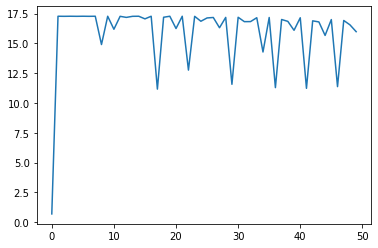

In [138]:
plt.plot(train_losses)

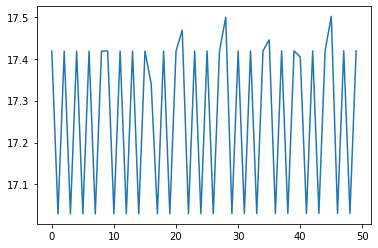

In [139]:
plt.plot(valid_losses)